## Implement a pipeline to cluster points with the help of HRD information

In [1]:
import sys
import os
import time
import matplotlib.pyplot as plt
import copy
import networkx as nx
import itertools

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors, KernelDensity
from scipy.sparse.csgraph import connected_components
from sklearn.mixture import GaussianMixture
from networkx.drawing.nx_pydot import graphviz_layout

#import plotly.graph_objects as go

In [2]:
sys.path.append('./core/')

In [3]:
from Modality.DensityEstKNN import DensityEstKNN
from Modality.kde_modality import KdeModality
from Modality.MergeGraph import MergeGraph
from Modality.merge_strategy import MergePaths
from miscellaneous.utils import pairwise_loop
from NoiseRemoval.RemoveNoiseTransformed import remove_noise_simple
from ScaleSpace.ScaleSpace import ScaleSpaceTree

# Import data

In [4]:
data_dict = {
    'skinny': {
        'path': './resources/skinnyDipData_8.csv',
        'read_csv_kwargs': {},
        'columns2keep': ['V2', 'V3', 'V4'],
        'rename_columns': {'V2': 'f1', 'V3': 'f2', 'V4': 'labels'},
        'astype': {'f1': np.float32, 'f2': np.float32, 'labels': np.int32},
    },
    'adawave': {
        'path': './resources/waveData_8.csv',
        'read_csv_kwargs': dict(header=None, names=['f1', 'f2', 'labels']),
        'columns2keep': ['f1', 'f2', 'labels'],
        'rename_columns': {},
        'astype': {'f1': np.float32, 'f2': np.float32, 'labels': np.int32}
    }
}

def csv2pandas(data_info):
    X = pd.read_csv(data_info['path'], **data_info['read_csv_kwargs'])
    X = X[data_info['columns2keep']]
    X = X.rename(columns=data_info['rename_columns'])
    X = X.dropna()
    X = X.astype(data_info['astype'])
    return X, data_info['columns2keep']

In [5]:
X, _ = csv2pandas(data_dict['adawave'])
cluster_cols = ['f1', 'f2']
df_cluster = X[cluster_cols]

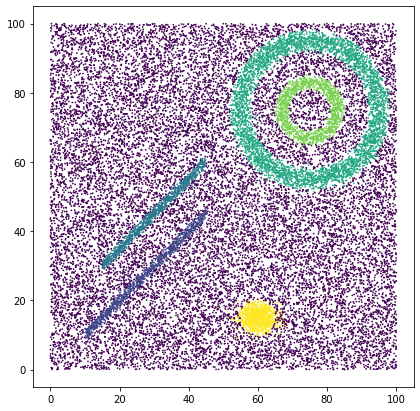

In [6]:
plt.figure(figsize=(7,7))
plt.scatter(X['f1'], X['f2'], c=X['labels'], s=0.5)
plt.gca().set_aspect('equal')
plt.show()

# Estimate denstiy

In [7]:
de = DensityEstKNN(df_cluster.values, max_neighbors=200)

# Extract dense components & track them through scale space

In [8]:
data_idx = np.arange(X.shape[0])
sst = ScaleSpaceTree(data_size=X.shape[0], min_jaccard_sim=0.5)

In [12]:
knn_densities_ssp = [30,50,70,90,110,130]

for nb_neighs in knn_densities_ssp:
    kwargs = {'knn_density': nb_neighs, 'knn_neighors_graph': 30, 'alpha': 0.05}

    ## Determine maximum distance
    # Mean distance to the knn_density neighbor -> on average there are knn_density neighbors within a radius of max_dist
    nn = NearestNeighbors(n_jobs=-1).fit(df_cluster.values)
    dist, _ = nn.kneighbors(n_neighbors=kwargs['knn_density'], return_distance=True)
    max_dist = np.median(np.percentile(dist, q=90, axis=1))

    rho = de.knn_density(kwargs['knn_density'])
    #kde = KernelDensity(bandwidth=max_dist/2, atol=1e-6, rtol=1e-5).fit(df_cluster.values)
    #rho = np.exp(kde.score_samples(df_cluster.values)

    # Morse complex/ascending manifold
    mer_gr = MergeGraph(kwargs['knn_neighors_graph'])
    G, lbls, msfull = mer_gr.fit(df_cluster.values, rho)
    
    # Merge paths
    mp = MergePaths(data=df_cluster, graph=G, merge_sequence=msfull, density=rho, labels=lbls, max_dist=max_dist)
    sig_dip, cldict = mp.fit(alpha=kwargs['alpha'])
    fc = mp.flat_clustering()
    print(f'{np.unique(fc).size} cluster found with {nb_neighs} nn density')
    
    # Remove noise
    modes_final = {}
    for uid in np.unique(fc):
        ba = remove_noise_simple(data=df_cluster, cluster_bool_arr=fc==uid, G=G, labels=lbls, density=rho)
        clidx = data_idx[ba]
        mode_idx = clidx[np.argmax(rho[clidx])]
        modes_final[mode_idx] = {'index': clidx, 'boolarr': ba}
    # add partition to the scale space
    part = {key: value['index'] for key, value in modes_final.items()}
    sst.next_scale(partitions=part)

/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


5 cluster found with 30 nn density


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


5 cluster found with 50 nn density


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


5 cluster found with 70 nn density


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


5 cluster found with 90 nn density


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


5 cluster found with 110 nn density


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"
/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


5 cluster found with 130 nn density


In [13]:
ssp_clusters = sst.scale_space_clusters

In [14]:
G_ssp = nx.Graph()
G_ssp.add_nodes_from(ssp_clusters.keys())
for cli in ssp_clusters.keys():
    for child in ssp_clusters[cli].child_list:
        G_ssp.add_edge(cli, child)

In [15]:
cc_ssp = sorted([list(cc) for cc in nx.connected_components(G_ssp)], key=len)
cc_ssp

[[0, 5, 10, 15, 20, 25],
 [1, 6, 11, 16, 21, 26],
 [2, 7, 12, 17, 22, 27],
 [3, 8, 13, 18, 23, 28],
 [4, 9, 14, 19, 24, 29]]

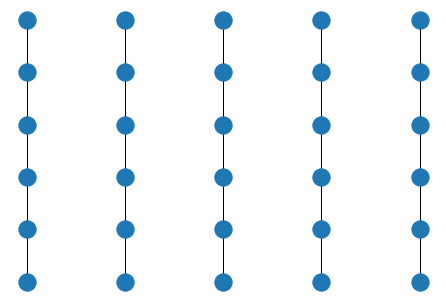

{0: [27.0, 378.0], 1: [99.0, 378.0], 2: [171.0, 378.0], 3: [243.0, 378.0], 4: [315.0, 378.0], 5: [27.0, 306.0], 6: [99.0, 306.0], 7: [171.0, 306.0], 8: [243.0, 306.0], 9: [315.0, 306.0], 10: [27.0, 234.0], 11: [99.0, 234.0], 12: [171.0, 234.0], 13: [243.0, 234.0], 14: [315.0, 234.0], 15: [27.0, 162.0], 16: [99.0, 162.0], 17: [171.0, 162.0], 18: [243.0, 162.0], 19: [315.0, 162.0], 20: [27.0, 90.0], 21: [99.0, 90.0], 22: [171.0, 90.0], 23: [243.0, 90.0], 24: [315.0, 90.0], 25: [27.0, 18.0], 26: [99.0, 18.0], 27: [171.0, 18.0], 28: [243.0, 18.0], 29: [315.0, 18.0]}


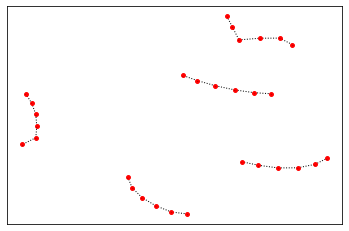

In [16]:
# Might have to call the function multiple times since different connected components might overlap
pos = graphviz_layout(G_ssp, prog="dot")
nx.draw(G_ssp, pos)


plt.show()


for key in pos:
    pos[key] = list(pos[key])


print(dict(pos))

nx.draw_networkx(G_ssp, node_size=15, node_color='r', font_size=0, style="dotted") #, ax=plt.gca())

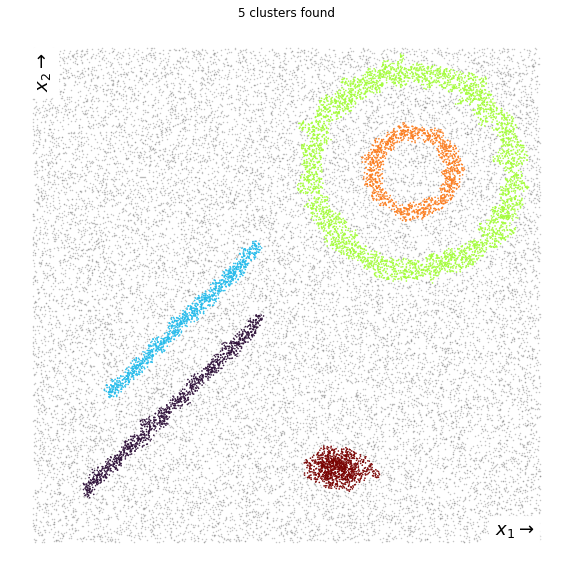

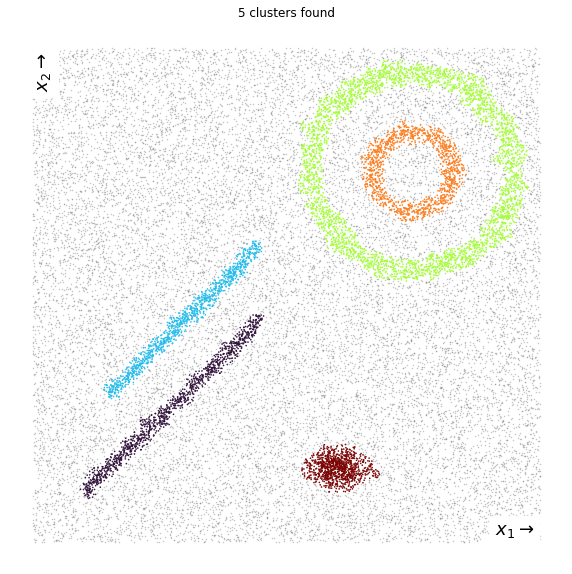

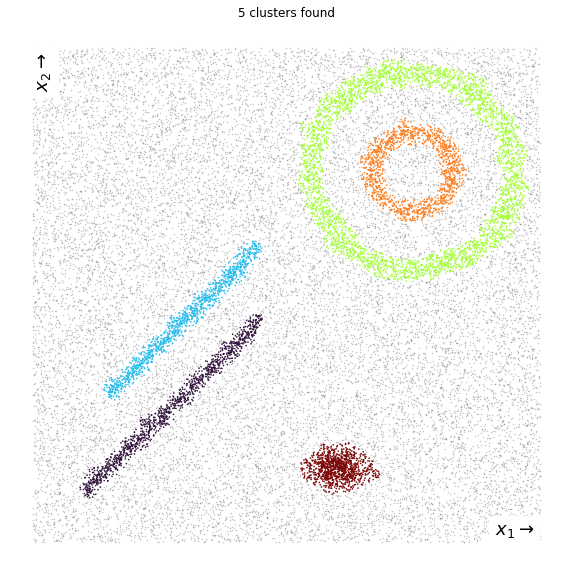

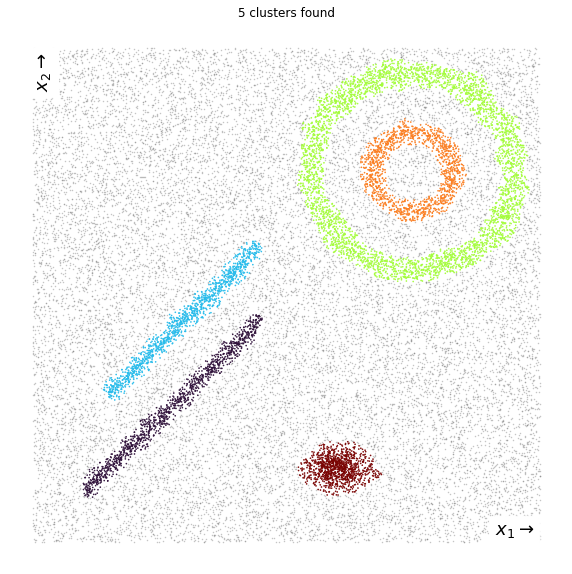

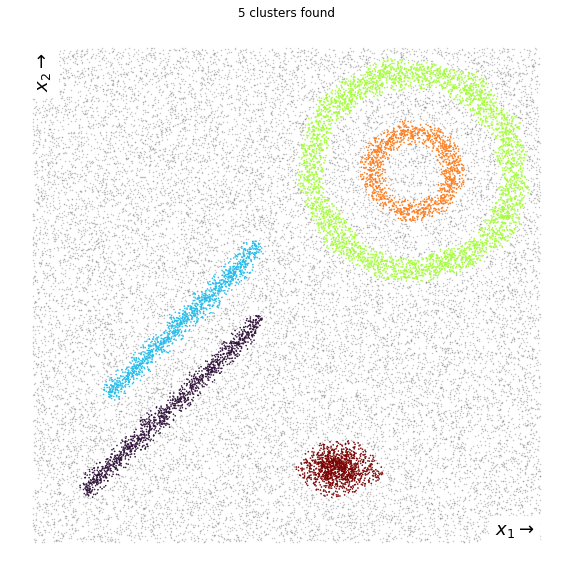

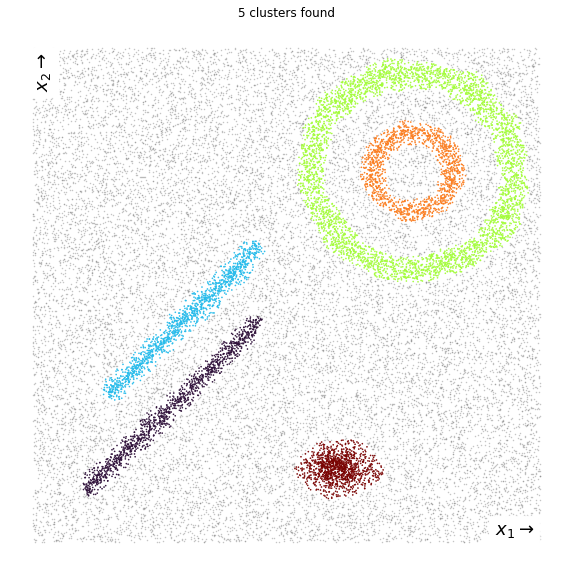

In [21]:
for i in range(len(knn_densities_ssp)):
    fc = sst.labels_from_scale(i)
    
    #for plt_cluster in mp.clusters.values():
    plt.figure(figsize=(10,10))
    plt.scatter(X.loc[fc==-1, 'f1'], X.loc[fc==-1, 'f2'], s=0.2, c='tab:grey', alpha=0.5)
    plt.scatter(X.loc[fc!=-1, 'f1'], X.loc[fc!=-1, 'f2'], s=0.4, c=fc[fc!=-1], cmap='turbo')
    plt.title(f'{np.unique(fc[fc!=-1]).size} clusters found')
    # ------ Style -------
    text_size = 18
    gray_tone = 1
    color_gray = (gray_tone, gray_tone, gray_tone)
    axes_tone_gray = 0
    color_axes = (axes_tone_gray, axes_tone_gray, axes_tone_gray)
    plt.gca().set_facecolor(color_gray)

    xlabel, ylabel = r'$x_1 \rightarrow$', r'$x_2 \rightarrow$'
    plt.annotate(xlabel, xy=(0.945,0.05), xycoords='axes fraction', va='bottom', ha='right', size=text_size, 
                 bbox=dict(boxstyle='round', fc=color_gray, color=color_gray), color=color_axes)
    plt.annotate(ylabel, xy=(0.05, 0.945), xycoords='axes fraction', va='top', ha='left', size=text_size, rotation=90,
                 bbox=dict(boxstyle='round', fc=color_gray, color=color_gray), color=color_axes)
    plt.gca().get_yaxis().set_ticklabels([])
    plt.gca().get_yaxis().set_ticks([])
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_xaxis().set_ticklabels([]);
    for direction in ['left', 'right', 'top', 'bottom']:
        plt.gca().spines[direction].set_visible(False)

    #plt.savefig(f'/home/sebastian/Desktop/plots/skinny_modes_singleclust.png', bbox_inches='tight');
    plt.show()